In [1]:
#Make essential imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Problem formulation:

Inputs: Volts, Ampers

Output: Battery time left

The idea so is to output the battery remaining time (in minutes), given

current current consumption and voltage level.

The idea is clearly explained in the following graph:

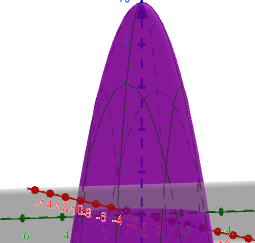

The extracted graph from the datasheet is the following:
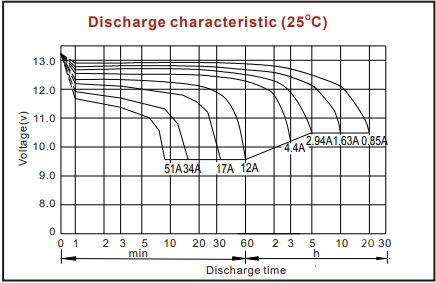

# Data creation

In [222]:
"""
Using WebPlotDigitalizer we extracted valuable information about the graph, and so constructed a dataset.
Cite:
@misc{Rohatgi2022,
  url = {https://automeris.io/WebPlotDigitizer},
  author = {Rohatgi,  Ankit},
  title = {Webplotdigitizer: Version 4.6},
  year = {2022}
}
"""
#Load the datasets
first = pd.read_csv('datasets/0-1.csv')
second = pd.read_csv('datasets/1-2.csv')
third = pd.read_csv('datasets/2-3.csv')
fourth = pd.read_csv('datasets/3-5.csv')
fifth = pd.read_csv('datasets/5-10.csv')
sixth = pd.read_csv('datasets/10-20.csv')
seventh = pd.read_csv('datasets/20-30.csv')
eighth = pd.read_csv('datasets/30-60.csv')
ninth = pd.read_csv('datasets/60-120.csv')
tenth = pd.read_csv('datasets/120-180.csv')
eleventh = pd.read_csv('datasets/180-300.csv')
twelth = pd.read_csv('datasets/300-600.csv')
thirtheenth = pd.read_csv('datasets/600-1200.csv')
dataframes = [first, second, third, fourth, fifth, sixth, seventh, eighth, ninth, tenth, eleventh, twelth, thirtheenth]

In [223]:
#We get the possible current values (the ones that the datasheet provides)
currents = [i.split('A')[0] for i in first.columns[[not('Unnamed' in i) for i in first.columns]]]
currents

['0.85', '1.63', '2.94', '4.4', '12', '17', '34', '51']

In [224]:
#Create an empty dataframe where the whole data will be dumped
df = pd.DataFrame(data={'Time':[], 'Volts':[], 'Ampers':[]})
df

,Time,Volts,Ampers


In [225]:
#This function joins every single datapoint related to a given current
def join_dataset(current:str, datasets:list):
    data_join = np.array([[0, 0, 0]])
    for dataset in datasets:
        in_col = [current in i.split('A')[0] for i in dataset.columns]
        if np.sum(in_col) == 1:
            #We first get the index of the current (ampers) column
            col_idx = np.argmax(in_col)
            #Then we obtain the fraction of the dataset related to that current
            temp_data = dataset.iloc[1:, [col_idx, col_idx+1]].dropna().astype(float)
            col_curr = np.full(len(temp_data), float(current))
            temp_data.insert(1, 'Ampers', col_curr)
            #Finally the new data is concatenated to the one previously processed
            data_join = np.concatenate((data_join, temp_data.to_numpy()), axis=0)
    return data_join[1:]

In [226]:
full_datasets = [join_dataset(i, dataframes) for i in currents]
full_datasets

[array([[2.90015198e-02, 8.50000000e-01, 1.32030980e+01],
        [6.07877055e-02, 8.50000000e-01, 1.31977204e+01],
        [8.53497580e-02, 8.50000000e-01, 1.31874599e+01],
        ...,
        [1.03930615e+03, 8.50000000e-01, 1.11413544e+01],
        [1.03518433e+03, 8.50000000e-01, 1.11610543e+01],
        [1.03106251e+03, 8.50000000e-01, 1.11739020e+01]]),
 array([[8.77394713e-03, 1.63000000e+00, 1.31873362e+01],
        [4.05601328e-02, 1.63000000e+00, 1.31750977e+01],
        [7.23463184e-02, 1.63000000e+00, 1.31645281e+01],
        ...,
        [5.92440655e+02, 1.63000000e+00, 1.05283318e+01],
        [5.93787709e+02, 1.63000000e+00, 1.06172942e+01],
        [5.94296902e+02, 1.63000000e+00, 1.05825195e+01]]),
 array([[-8.56397232e-03,  2.94000000e+00,  1.31917866e+01],
        [ 2.32222133e-02,  2.94000000e+00,  1.31775701e+01],
        [ 4.92290925e-02,  2.94000000e+00,  1.31614993e+01],
        ...,
        [ 2.98821430e+02,  2.94000000e+00,  1.05530904e+01],
        [ 2.98821

In [227]:
for i in range(len(currents)):
    df_aux = pd.DataFrame(data={'Time':full_datasets[i][:,0], 'Ampers':full_datasets[i][:,1], 'Volts': full_datasets[i][:,2]})
    df = pd.concat((df, df_aux), ignore_index=True)
df.head()

,Time,Volts,Ampers
0,0.029002,13.203098,0.85
1,0.060788,13.197720,0.85
2,0.085350,13.187460,0.85
3,0.133029,13.170647,0.85
4,0.164815,13.159954,0.85


In [228]:
# As the purpose of the model is to predict the battery's time left we have to set as the minimum voltage level
# the minimum voltage requested by the motor when turning on. This information was obtained experimenting with the motor.
# The minimum voltage is then: 10.2V
dt = df.loc[df.Volts >= 10.2].reset_index(drop=True)
dt

,Time,Volts,Ampers
0,0.029002,13.203098,0.85
1,0.060788,13.197720,0.85
2,0.085350,13.187460,0.85
3,0.133029,13.170647,0.85
4,0.164815,13.159954,0.85
...,...,...,...
5018,8.339763,10.251221,51.00
5019,8.355458,10.238067,51.00
5020,8.370486,10.225242,51.00
5021,8.392521,10.212645,51.00


In [229]:
#We have to set the remaining battery life for every current level based on how much did the battery lasted
for a in currents:
    mask = dt.Ampers == float(a)
    last_time = dt.loc[mask].Time.max()
    dt['Time'].loc[mask] = dt.loc[mask].Time.apply(lambda x: last_time-x) #The last_time-current_time gives the remaining time of the battery
dt

,Time,Volts,Ampers
0,1182.537041,13.203098,0.85
1,1182.505254,13.197720,0.85
2,1182.480692,13.187460,0.85
3,1182.433013,13.170647,0.85
4,1182.401227,13.159954,0.85
...,...,...,...
5018,0.073465,10.251221,51.00
5019,0.057770,10.238067,51.00
5020,0.042741,10.225242,51.00
5021,0.020706,10.212645,51.00


In [230]:
#We save the final data to a csv
dt.to_csv('data.csv', index=False)

# Data visualization

In [76]:
#Load the data
df = pd.read_csv('data.csv')
df.head()

,Time,Volts,Ampers
0,1182.537041,13.203098,0.85
1,1182.505254,13.197720,0.85
2,1182.480692,13.187460,0.85
3,1182.433013,13.170647,0.85
4,1182.401227,13.159954,0.85


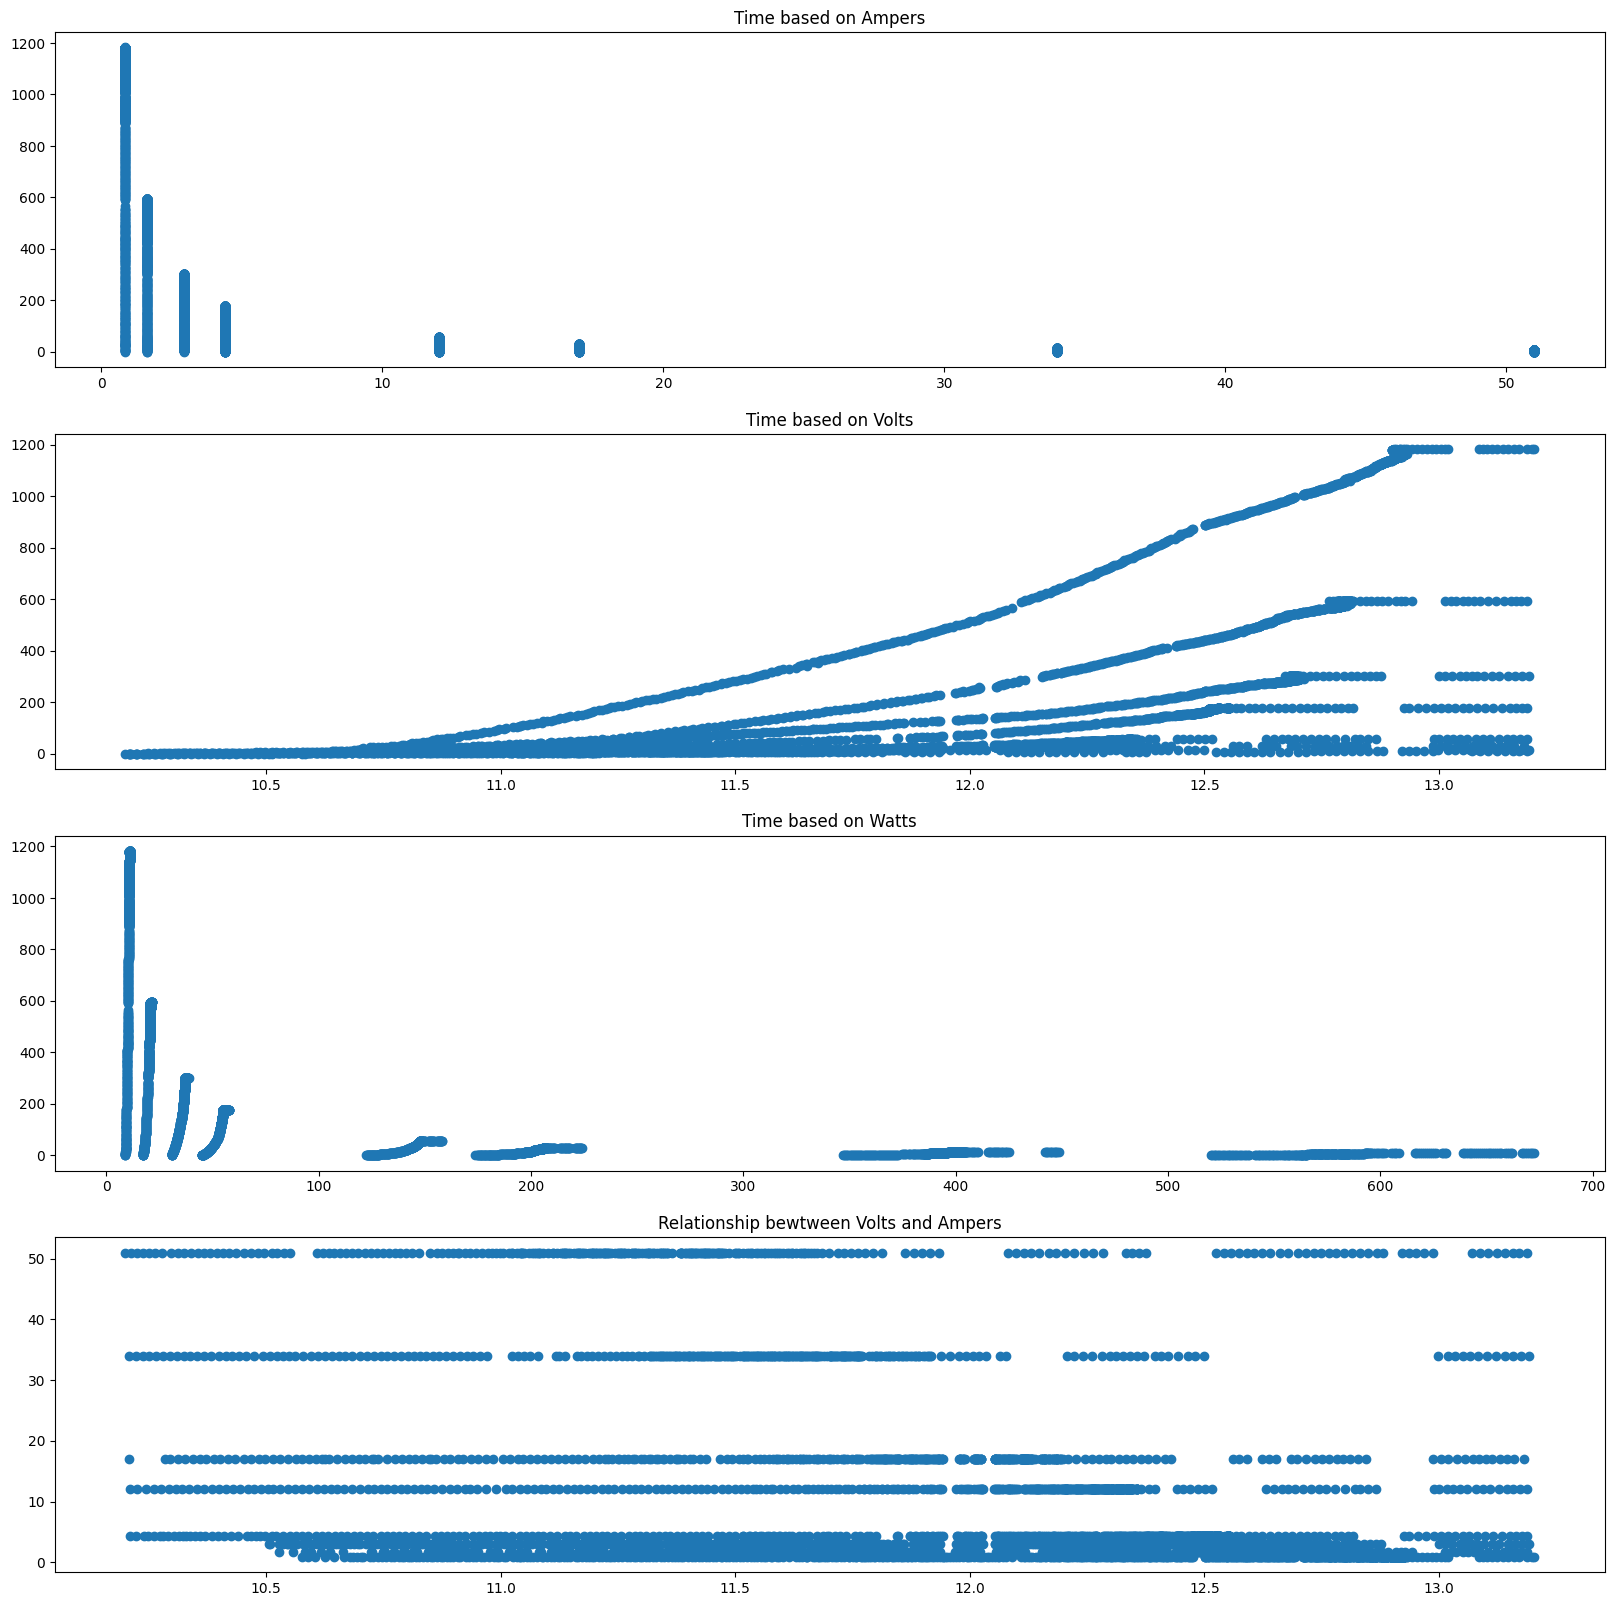

In [80]:
#Visualize the data in 2D scatterplots
data = df.to_numpy()
X = data[:, 1:]
y = data[:, 0]

figure, axis = plt.subplots(4, 1, figsize=(20, 20)) 

# For Ampers 
axis[0].scatter(X[:, 1], y) 
axis[0].set_title("Time based on Ampers") 
  
# For Volts 
axis[1].scatter(X[:, 0], y) 
axis[1].set_title("Time based on Volts") 

# For Watts (Volts*Ampers)
axis[2].scatter(X[:, 0]*X[:, 1], y) 
axis[2].set_title("Time based on Watts") 

# For Volts and Ampers
axis[3].scatter(X[:, 0], X[:, 1]) 
axis[3].set_title("Relationship bewtween Volts and Ampers") 

plt.show()

As we can see, there are no outliers and there does not seem to be any leverage point. The problem with the data is that it seems to be categorical in one axis and non-linear in another. Ampers seems to be categorical, and may be the case.

# Model fitting

In [2]:
#Load the data
df = pd.read_csv('data.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head()

,Time,Volts,Ampers
0,1182.537041,13.203098,0.85
1,1182.505254,13.197720,0.85
2,1182.480692,13.187460,0.85
3,1182.433013,13.170647,0.85
4,1182.401227,13.159954,0.85


In [3]:
#Setting up the data
data = df.to_numpy()
y = data[:, 0]
X = data[:, 1:]

data_train = df_train.to_numpy()
X_train, y_train = data_train[:, 1:], data_train[:, 0]

data_test =  df_test.to_numpy()
X_test, y_test =  data_test[:, 1:], data_test[:, 0]

In [4]:
#Normalize the data
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X-mean)/std
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std

In [5]:
#Helper function
def mean_diff(y_true:np.array, y_pred:np.array):
    return np.mean(abs(y_true-y_pred))

In [8]:
#We will first fit a linear regression to the data (the most basic model)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

lin_reg = LinearRegression()
kfold = KFold(n_splits = 5, shuffle=True, random_state=42)

ME = 0
for train, test in kfold.split(X, y):
    lin_reg.fit(X[train], y[train])
    ME += mean_diff(y[test], lin_reg.predict(X[test]))
ME/5 #This gives the average error

223.99828222670212

In [47]:
#Function to build high order polynomials
def build_features(X:np.array, degree:int):
    input = X
    for i in range(2, degree+1):
        exp_feat = X[:]**i
        input = np.concatenate((input, exp_feat), axis=1)
    return input

In [54]:
#As the mean error score was not good enough we create more predictors (for example Watts, Volts*Ampers)
watts = np.array([X[:, 0]*X[:, 1]])

max_degree = 50
loss = np.array([0]*(max_degree-1))

for i in range(2, max_degree+1):
    X_new = np.concatenate((X, watts.T), axis=1)

    #Feature engineering
    for j in range(i):
        data_exp = X[:]**j
        X_new = np.concatenate((X_new, data_exp), axis=1)
        X_old = X_new
    

    #Kfold evaluation
    for train, test in kfold.split(X_new, y):
        lin_reg.fit(X_new[train], y[train])
        loss[i-2] += mean_diff(y[test], lin_reg.predict(X_new[test]))/5

loss, 'Best degree: '+ str(np.argmin(loss))

(array([197, 173, 156, 113,  94,  62,  56,  55,  55,  56,  56,  54,  53,
         53,  53,  53,  52,  51,  51,  51,  50,  50,  50,  59,  63,  73,
         97,  57,  83, 199,  98, 117, 152, 228, 270, 267, 272, 271, 272,
        273, 270, 274, 278, 275, 275, 276, 278, 275, 275]),
 'Best degree: 20')

In [55]:
#Build features for polynomio of degree 20
watts_train = np.array([X_train[:, 0]*X_train[:, 1]])
X_new = np.concatenate((X_train, watts_train.T), axis=1)
X_new = build_features(X_new, 20)

#Train polynomio
lin_reg.fit(X_new, y_train)

LinearRegression()

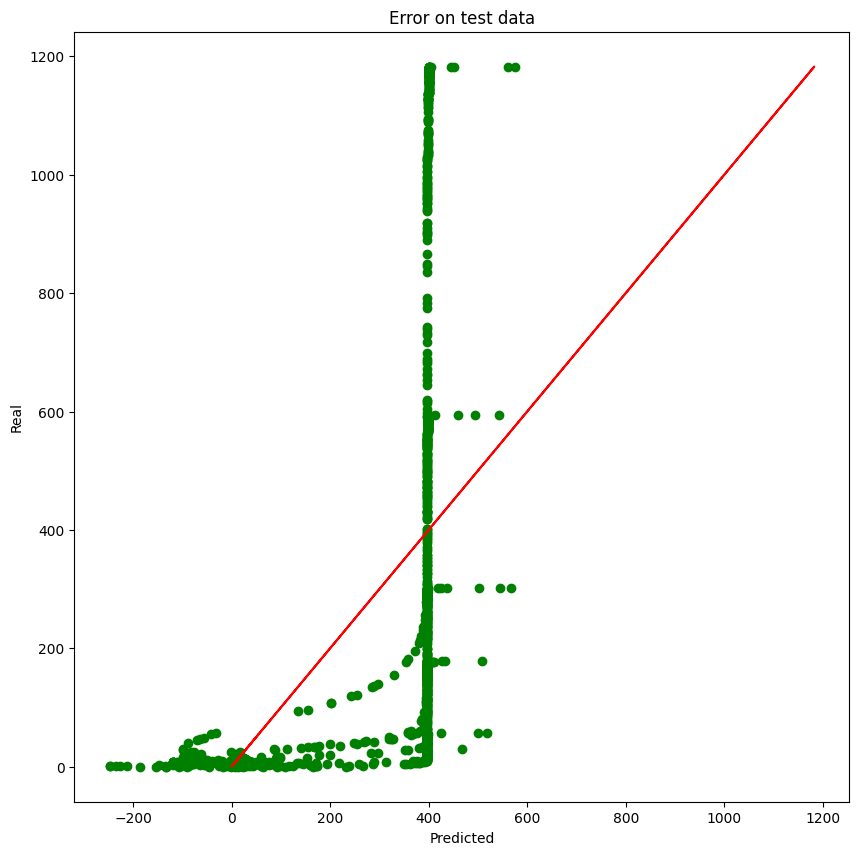

In [56]:
#Measure the fit of the polinomio and visualize the results
watts_test = np.array([X_test[:, 0]*X_test[:, 1]])
X_test_pol = np.concatenate((X_test, watts_test.T), axis=1)
X_test_pol = build_features(X_test_pol, 20)
y_pred_pol = lin_reg.predict(X_test_pol)

figure, axis = plt.subplots(1, 1, figsize=(10, 10)) 

# Visualize the error 
axis.scatter(y_pred_pol, y_test, color='green')
axis.plot(y_test, y_test, color='red')  
axis.set_title("Error on test data") 
axis.set_xlabel('Predicted')
axis.set_ylabel('Real')
plt.show()  

In [189]:
#Lets build a NN!!!

#The model should be as simple as possible, in order to reduce variance
model = keras.models.Sequential()
model.add(keras.Input(shape=(2,)))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_absolute_error"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                48        
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [191]:
#Fit the model
model.fit(X_train, y_train, batch_size=300,epochs=10000, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10000
12/12 - 1s - loss: 247690.5000 - mean_absolute_error: 325.4255 - val_loss: 254149.7812 - val_mean_absolute_error: 329.8526 - 707ms/epoch - 59ms/step
Epoch 2/10000
12/12 - 0s - loss: 247628.4531 - mean_absolute_error: 325.3481 - val_loss: 254083.8438 - val_mean_absolute_error: 329.7732 - 40ms/epoch - 3ms/step
Epoch 3/10000
12/12 - 0s - loss: 247560.1875 - mean_absolute_error: 325.2679 - val_loss: 254011.9688 - val_mean_absolute_error: 329.6898 - 42ms/epoch - 3ms/step
Epoch 4/10000
12/12 - 0s - loss: 247487.8438 - mean_absolute_error: 325.1836 - val_loss: 253933.2656 - val_mean_absolute_error: 329.6019 - 40ms/epoch - 3ms/step
Epoch 5/10000
12/12 - 0s - loss: 247411.9688 - mean_absolute_error: 325.0981 - val_loss: 253860.1406 - val_mean_absolute_error: 329.5159 - 43ms/epoch - 4ms/step
Epoch 6/10000
12/12 - 0s - loss: 247340.5156 - mean_absolute_error: 325.0101 - val_loss: 253781.7188 - val_mean_absolute_error: 329.4203 - 48ms/epoch - 4ms/step
Epoch 7/10000
12/12 - 0s - loss:

In [192]:
mean, std #Recall the mean and standard deviation values

(array([12.16983305,  9.41150109]), array([ 0.68739603, 13.52794009]))

In [266]:
#Example of model inference
X_pred = [13, 17]
X_pred = (X_pred-mean)/std
model(np.array([X_pred]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[32.101906]], dtype=float32)>

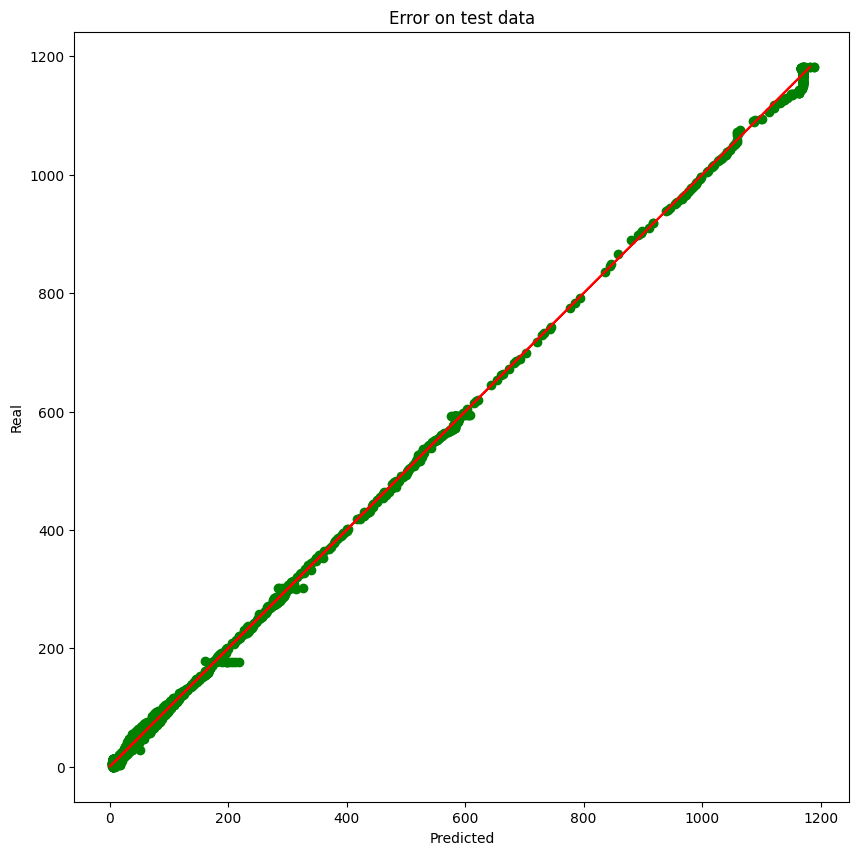

In [197]:
#Visualize the error of the model
y_pred = model(X_test).numpy()
figure, axis = plt.subplots(1, 1, figsize=(10, 10)) 

# Visualize the error 
axis.scatter(y_pred, y_test, color='green')
axis.plot(y_test, y_test, color='red')  
axis.set_title("Error on test data") 
axis.set_xlabel('Predicted')
axis.set_ylabel('Real')
plt.show()  

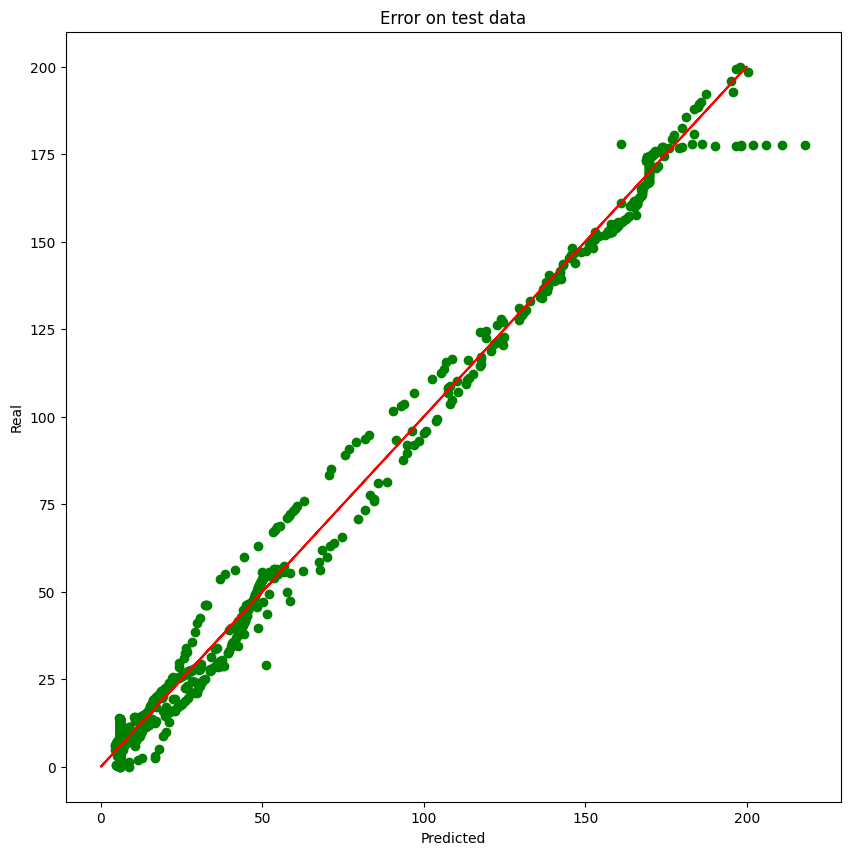

In [267]:
#We now focus on the most critical part (because the car will be consuming around 17A, so these are important points)
X_real, y_real = X_test[y_test <= 200], y_test[y_test <= 200]

figure, axis = plt.subplots(1, 1, figsize=(10, 10)) 
y_pred_r = model(X_real).numpy()

# Visualize the error 
axis.scatter(y_pred_r, y_real, color='green')
axis.plot(y_real, y_real, color='red')  
axis.set_title("Error on test data") 
axis.set_xlabel('Predicted')
axis.set_ylabel('Real')
plt.show()  

In [268]:
#Measure the mean deviation from the real value on the crucial points
np.sum(np.mean(abs(y_pred_r[:,0]-y_real)))

3.9871654735046484

In [232]:
#Save trained model to use it later
model.save('eco_model.keras')

In [233]:
#Load pretrained model
load_model = keras.models.load_model("eco_model.keras")
load_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                48        
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 


Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
